In [21]:
import pyspark
from pyspark.sql import SparkSession

In [22]:
spark = SparkSession.builder.appName("Spark_RDD").getOrCreate()

In [23]:
spark

In [24]:
# read the dataset
df = spark.read.csv("US_Accident_March23_small.csv", header=True, inferSchema=True)
df.show(5)

+---------+-------+--------+-------------------+-------------------+------------------+-----------+---------+-------------------+--------------------+--------------------+-----------------+-------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|       ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|  Start_Lng|  End_Lat|            End_Lng|        Distance(mi)|         Description|           Street|         City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|P

In [25]:
# check the schema, check the data types
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [26]:
type(df)

pyspark.sql.dataframe.DataFrame

In [50]:
# show all the rows with NA values
df.na.drop(how="any", thresh=2).count()

5000

In [31]:
# select a column
severity_with_location = df.select(["Start_Lat", "Start_Lng", "Severity"])
state_with_location = df.select(["Start_Lat", "Start_Lng", "State"])

In [32]:
state_with_location.dtypes

[('Start_Lat', 'double'), ('Start_Lng', 'double'), ('State', 'string')]

# Visualize by cooridante and state

In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Step 1: Prepare your data
# Assuming df is your original DataFrame with 'Start_Lat', 'Start_Lng', and 'State'
# Filter or sample the data if necessary
df_sampled = df.select("Start_Lat", "Start_Lng", "State").toPandas().dropna()

# Optionally, sample the data for better performance if the dataset is very large
df_sampled = df_sampled.sample(n=10000, random_state=4651)

# Step 2: Create a base map
# Center the map on the mean latitude and longitude of the dataset
center_lat = df_sampled["Start_Lat"].mean()
center_lng = df_sampled["Start_Lng"].mean()
m = folium.Map(location=[center_lat, center_lng], zoom_start=5)

# Step 3: Prepare data for the heatmap
# Convert latitude and longitude into a list of coordinate pairs
heat_data = df_sampled[["Start_Lat", "Start_Lng"]].values.tolist()

# Step 4: Add the heatmap layer
HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(m)

# Step 5: Display and save the map
m.save("accidents_heatmap.html")
m

# Accident Duration Analysis

In [68]:
accident_duration_df = df.select("Start_Time", "End_Time", "Severity").dropna().withColumn("Duration", (df.End_Time - df.Start_Time)).toPandas()
accident_duration_df["Duration_Seconds"] = accident_duration_df[
    "Duration"
].dt.total_seconds()

In [69]:
accident_duration_df.head(5)

,Start_Time,End_Time,Severity,Duration,Duration_Seconds
0,2020-05-08 17:26:49,2020-05-08 17:56:49,2,0 days 00:30:00,1800.0
1,2017-01-27 12:04:22,2017-01-27 12:34:01,2,0 days 00:29:39,1779.0
2,2019-07-18 15:58:44,2019-07-18 19:58:44,2,0 days 04:00:00,14400.0
3,2019-11-08 16:28:09,2019-11-08 16:57:58,2,0 days 00:29:49,1789.0
4,2022-03-20 18:10:00,2022-03-20 20:17:51,2,0 days 02:07:51,7671.0


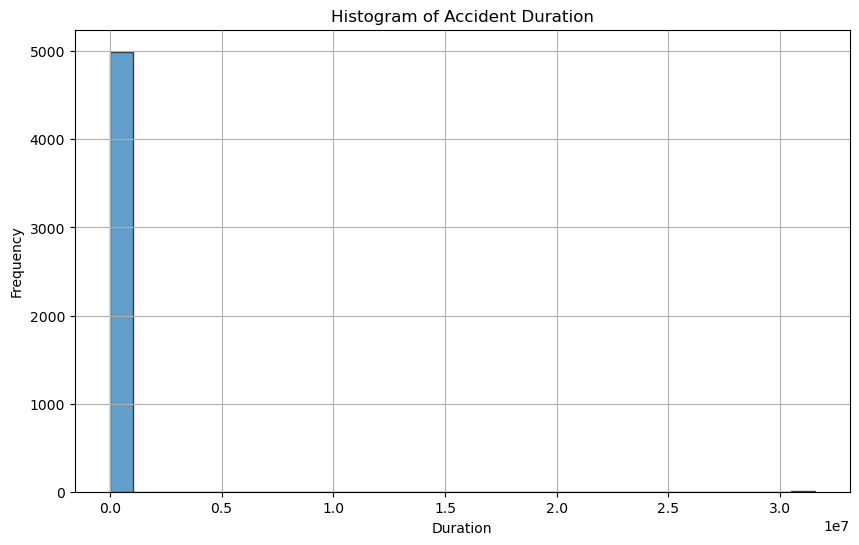

In [70]:
# plot a histogram of the duration of the accidents
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(accident_duration_df["Duration_Seconds"], bins=30, edgecolor="k", alpha=0.7)
plt.title("Histogram of Accident Duration")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Year Analysis

In [83]:
# group by year and count the number of accidents
from pyspark.sql.functions import year

df_by_year = df.groupBy(year("Start_Time")).count().toPandas()
df_by_year = df_by_year.sort_values(by="year(Start_Time)").reset_index(drop=True)

In [84]:
df_by_year

,year(Start_Time),count
0,2016,266
1,2017,454
2,2018,567
3,2019,625
4,2020,748
5,2021,1034
6,2022,1142
7,2023,164


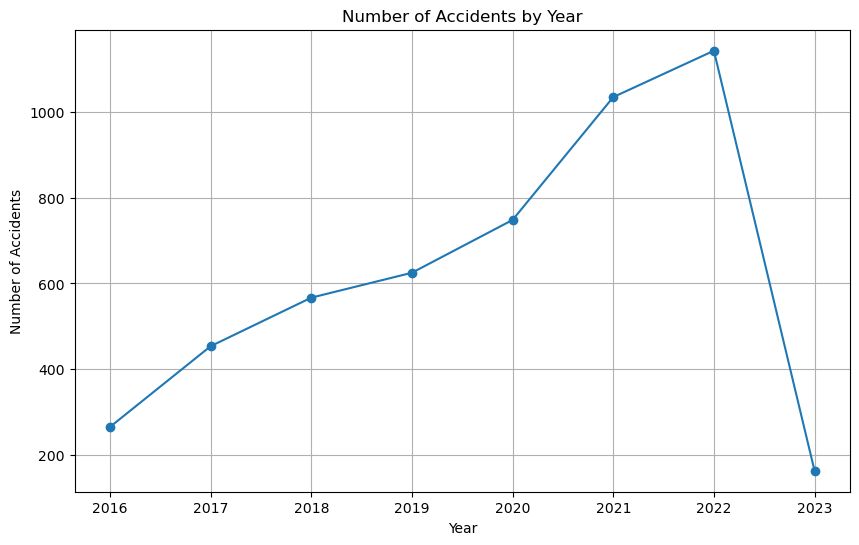

In [85]:
# please plot df_by_year as a line chart, The x-axis is the year, the y-axis is the number of accidents
plt.figure(figsize=(10, 6))
plt.plot(df_by_year["year(Start_Time)"], df_by_year["count"], marker="o")
plt.title("Number of Accidents by Year")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.show()

In [102]:
from pyspark.sql.functions import year

# Select the required columns
df_selected = df.select("Severity", "Start_Time")

# Extract year from Start_Time and group by Severity and year
df_grouped = df_selected.groupBy("Severity", year("Start_Time").alias("Year")).count()

# Convert to Pandas for inspection (optional)
df_grouped_pandas = df_grouped.toPandas()
df_grouped_pandas

,Severity,Year,count
0,3,2017,138
1,3,2018,178
2,4,2021,19
3,2,2016,186
4,4,2019,18
5,2,2022,1044
6,4,2016,4
7,3,2022,42
8,2,2023,157
9,1,2022,26


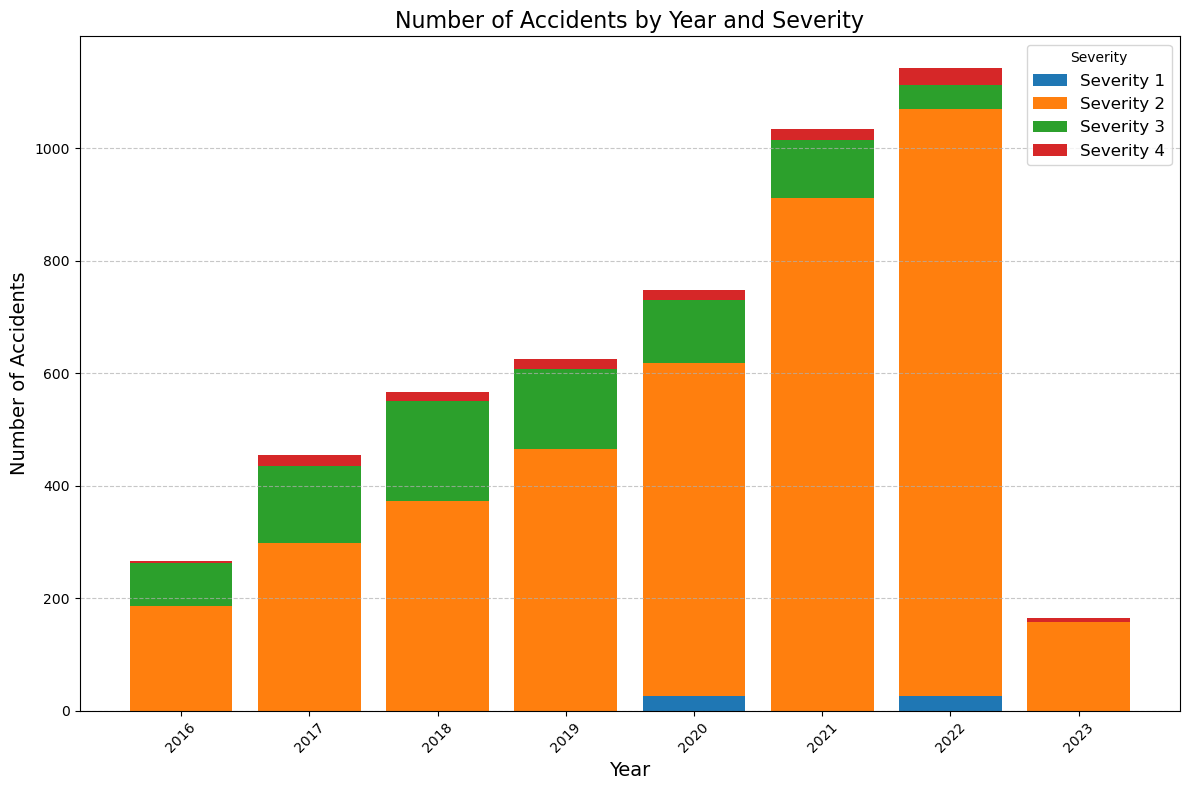

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_grouped_pandas is the grouped data in Pandas DataFrame format
# Pivot the data to make years the index, severity classes the columns, and counts the values
pivot_data = df_grouped_pandas.pivot(
    index="Year", columns="Severity", values="count"
).fillna(0)

# Sort the years for better visualization
pivot_data = pivot_data.sort_index()

# Plot the stacked bar chart
plt.figure(figsize=(12, 8))
severity_classes = pivot_data.columns  # Get the severity classes
bottom = None  # Used for stacking bars

# Plot each severity class as a segment of the stacked bar
for severity in severity_classes:
    if bottom is None:
        bar = plt.bar(
            pivot_data.index, pivot_data[severity], label=f"Severity {severity}"
        )
        bottom = pivot_data[severity]
    else:
        bar = plt.bar(
            pivot_data.index,
            pivot_data[severity],
            bottom=bottom,
            label=f"Severity {severity}",
        )
        bottom += pivot_data[severity]

# Add labels, title, and legend
plt.title("Number of Accidents by Year and Severity", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)
plt.xticks(pivot_data.index, rotation=45)
plt.legend(title="Severity", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

## Group by year and visualize with state

In [143]:
# Step 1: Prepare your data
# Assuming df is your original Spark DataFrame with 'Start_Time', 'Start_Lat', and 'Start_Lng'
# Extract year from 'Start_Time' and convert to Pandas DataFrame
df_with_year = df.selectExpr(
    "year(Start_Time) as Year", "Start_Lat", "Start_Lng"
).toPandas()

# Step 2: Filter data for each year and create heatmaps
years = df_with_year["Year"].unique()  # Get the unique years
heatmaps = {}  # Dictionary to store heatmaps for each year

for year in sorted(years):
    # Filter data for the specific year
    df_filtered = df_with_year[df_with_year["Year"] == year].dropna()

    # Skip years with no data
    if df_filtered.empty:
        continue

    # Create a base map centered on the dataset
    center_lat = df_filtered["Start_Lat"].mean()
    center_lng = df_filtered["Start_Lng"].mean()
    m = folium.Map(location=[center_lat, center_lng], zoom_start=5)

    # Prepare heatmap data for the year
    heat_data = df_filtered[["Start_Lat", "Start_Lng"]].values.tolist()

    # Add heatmap layer
    HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(m)

    # Save the map to the dictionary for later access
    heatmaps[year] = m

    # Save the map as an HTML file for viewing
    m.save(f"accidents_heatmap_{year}.html")



In [149]:
# Display one example heatmap interactively (e.g., the first year)
list(heatmaps.values())[5]

# trend of each state

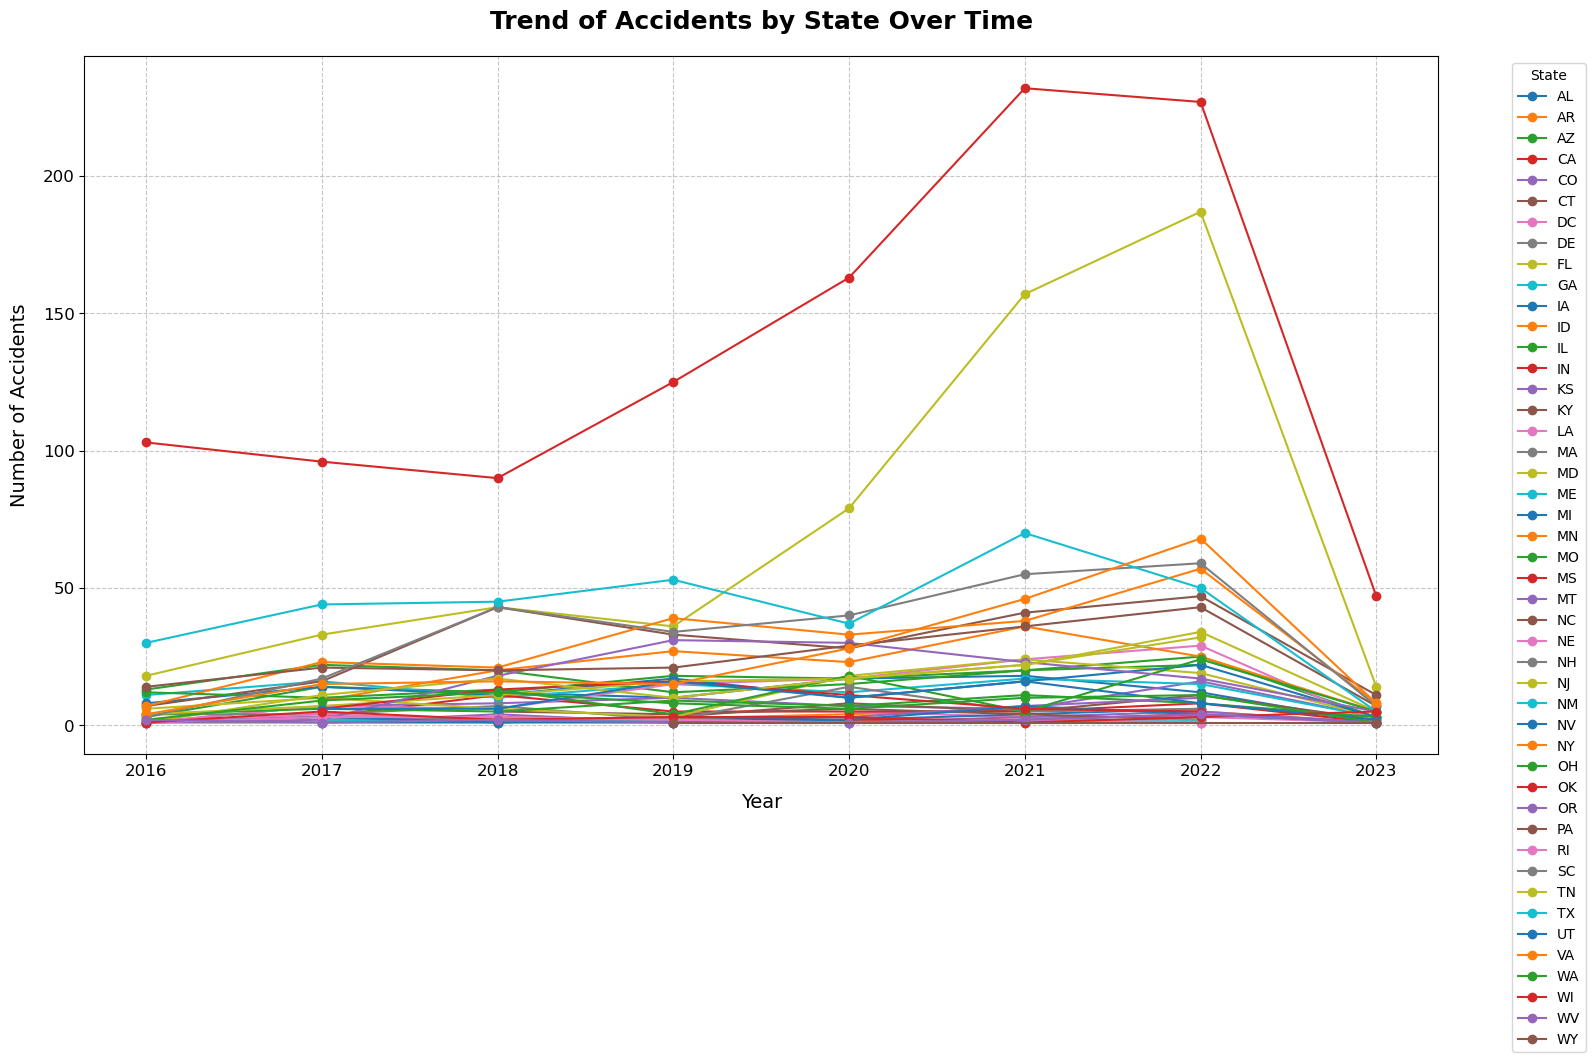

In [156]:
from pyspark.sql.functions import year
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Extract state and year from the dataframe and convert to RDD
rdd = df.selectExpr("State", "year(Start_Time) as Year").rdd

# Step 2: Map each record to a key-value pair and count occurrences using reduceByKey
# Key: (State, Year), Value: 1
rdd_grouped = rdd.map(lambda row: ((row["State"], row["Year"]), 1)).reduceByKey(
    lambda a, b: a + b
)

# Step 3: Collect results and convert to Pandas DataFrame for plotting
data = rdd_grouped.map(lambda x: (x[0][0], x[0][1], x[1])).collect()
df_trend = pd.DataFrame(data, columns=["State", "Year", "Count"])

# Step 4: Sort the data for each state by year
df_trend = df_trend.sort_values(by=["State", "Year"]).reset_index(drop=True)

# Step 5: Plot the trend of accidents for each state
plt.figure(figsize=(16, 10))

# Generate a line plot for each state
states = df_trend["State"].unique()
for state in states:
    state_data = df_trend[df_trend["State"] == state]
    plt.plot(
        state_data["Year"],
        state_data["Count"],
        marker="o",
        label=state,
    )

# Add labels, title, and legend
plt.title(
    "Trend of Accidents by State Over Time", fontsize=18, fontweight="bold", pad=20
)
plt.xlabel("Year", fontsize=14, labelpad=10)
plt.ylabel("Number of Accidents", fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.legend(
    title="State", fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left"
)  # Place legend outside the plot
plt.tight_layout()

# Show the plot
plt.show()

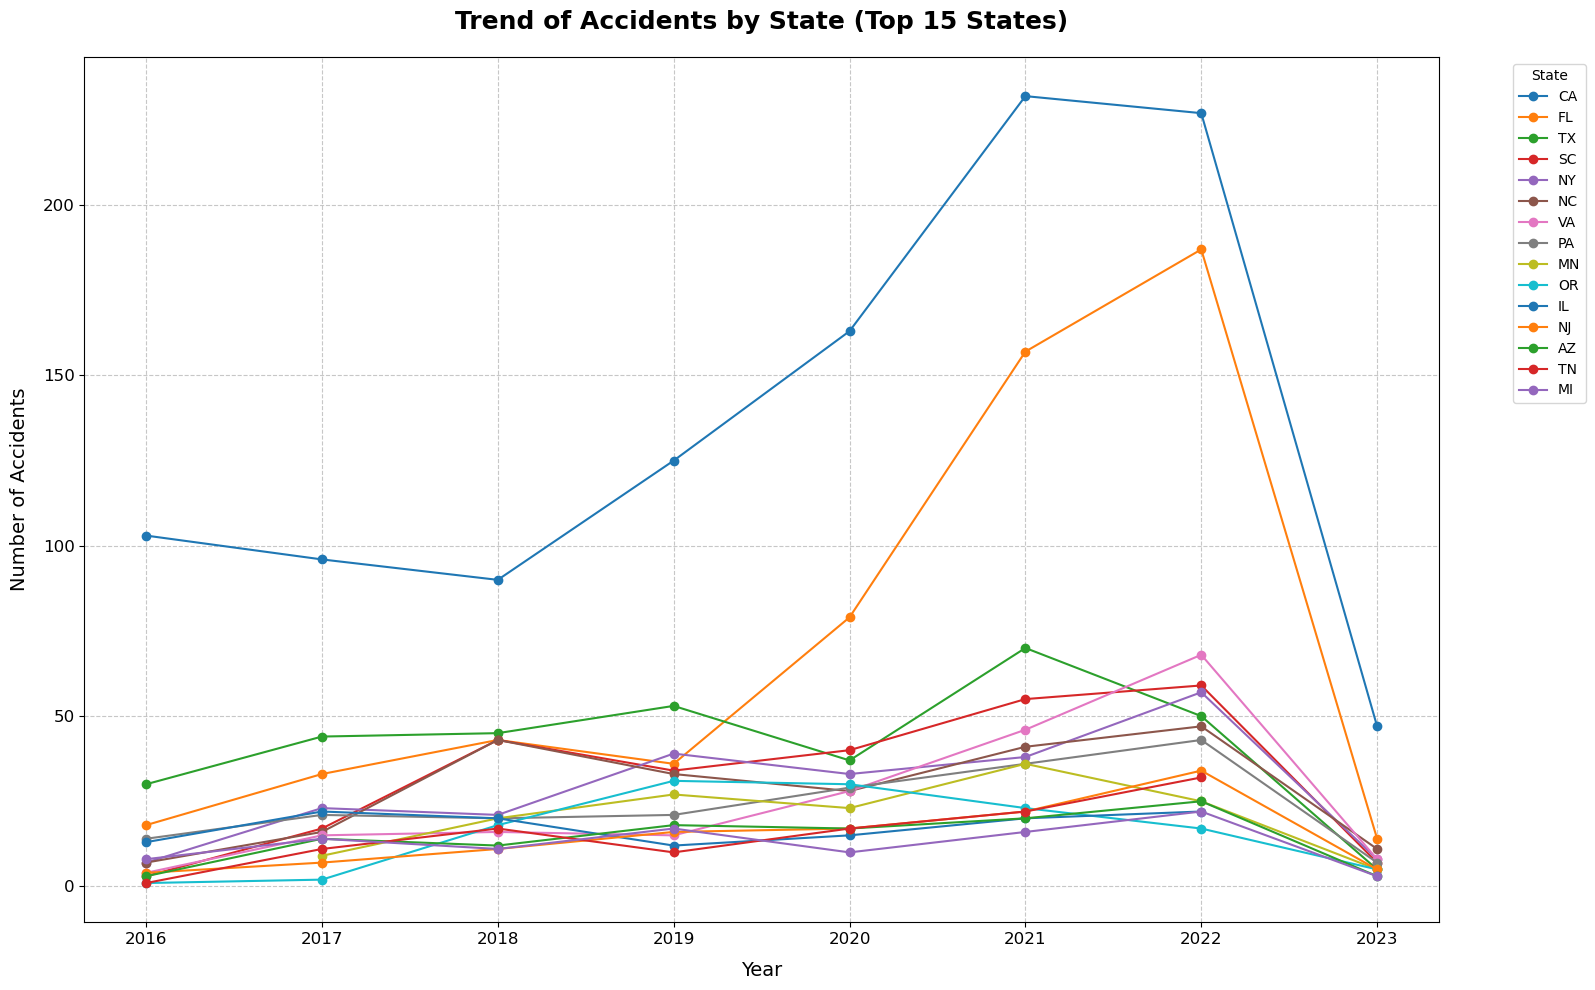

In [157]:
from pyspark.sql.functions import year
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Extract state and year from the dataframe and convert to RDD
rdd = df.selectExpr("State", "year(Start_Time) as Year").rdd

# Step 2: Map each record to a key-value pair and count occurrences using reduceByKey
# Key: (State, Year), Value: 1
rdd_grouped = rdd.map(lambda row: ((row["State"], row["Year"]), 1)).reduceByKey(
    lambda a, b: a + b
)

# Step 3: Collect results and convert to Pandas DataFrame for trend analysis
data = rdd_grouped.map(lambda x: (x[0][0], x[0][1], x[1])).collect()
df_trend = pd.DataFrame(data, columns=["State", "Year", "Count"])

# Step 4: Calculate the total number of accidents for each state
df_total_accidents = df_trend.groupby("State")["Count"].sum().reset_index()
df_total_accidents = df_total_accidents.sort_values(by="Count", ascending=False).head(
    15
)

# Step 5: Filter the trend data to include only the top 15 states
top_states = df_total_accidents["State"].tolist()
df_trend_filtered = df_trend[df_trend["State"].isin(top_states)]

# Step 6: Sort the filtered data for each state by year
df_trend_filtered = df_trend_filtered.sort_values(by=["State", "Year"]).reset_index(
    drop=True
)

# Step 7: Plot the trend of accidents for the top 15 states
plt.figure(figsize=(16, 10))

# Generate a line plot for each state
for state in top_states:
    state_data = df_trend_filtered[df_trend_filtered["State"] == state]
    plt.plot(
        state_data["Year"],
        state_data["Count"],
        marker="o",
        label=state,
    )

# Add labels, title, and legend
plt.title(
    "Trend of Accidents by State (Top 15 States)",
    fontsize=18,
    fontweight="bold",
    pad=20,
)
plt.xlabel("Year", fontsize=14, labelpad=10)
plt.ylabel("Number of Accidents", fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.legend(
    title="State", fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left"
)  # Place legend outside the plot
plt.tight_layout()

# Show the plot
plt.show()

# Accident by Month

## group by Month

In [86]:
# group by month and count the number of accidents
from pyspark.sql.functions import month

df_by_month = df.groupBy(month("Start_Time")).count().toPandas()
df_by_month = df_by_month.sort_values(by="month(Start_Time)").reset_index(drop=True)

In [87]:
df_by_month

,month(Start_Time),count
0,1,522
1,2,448
2,3,361
3,4,400
4,5,341
5,6,329
6,7,305
7,8,395
8,9,401
9,10,425


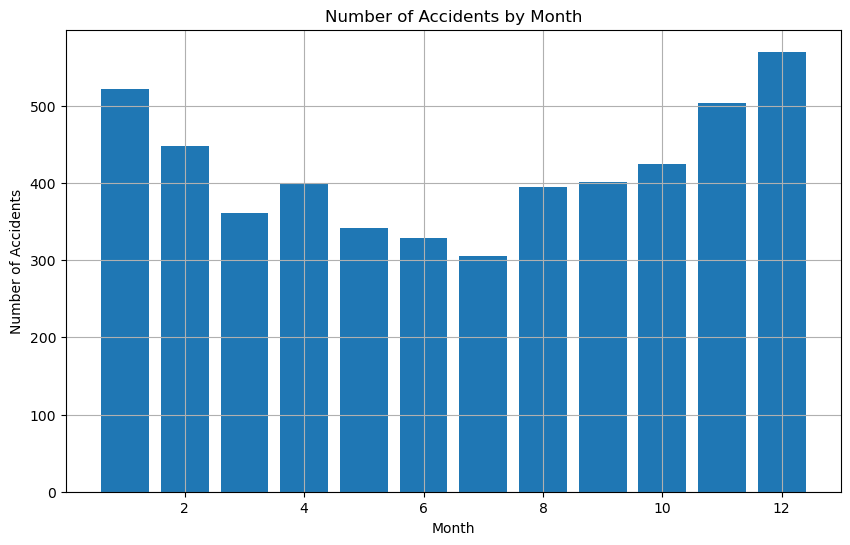

In [88]:
# show a bar chart of the number of accidents by month
plt.figure(figsize=(10, 6))
plt.bar(df_by_month["month(Start_Time)"], df_by_month["count"])
plt.title("Number of Accidents by Month")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.show()

## Group by month + Severity

In [124]:
# Step 1: Extract relevant columns and convert to RDD
rdd = df.select("Start_Time", "Severity").rdd.map(
    lambda row: (row["Start_Time"].month, row["Severity"])
)  # Extract month and severity

In [125]:
# Step 2: Map to key-value pairs and count occurrences
rdd_grouped = rdd.map(
    lambda x: ((x[0], x[1]), 1)
).reduceByKey(  # Key: (Month, Severity), Value: 1
    lambda a, b: a + b
)  # Aggregate counts

In [126]:
# Step 3: Convert to a more structured format for plotting
data = rdd_grouped.map(lambda x: (x[0][0], x[0][1], x[1])).collect()
df_grouped = pd.DataFrame(data, columns=["Month", "Severity", "Count"])

In [128]:
df_grouped = df_grouped.sort_values(by="Month").reset_index(drop=True)

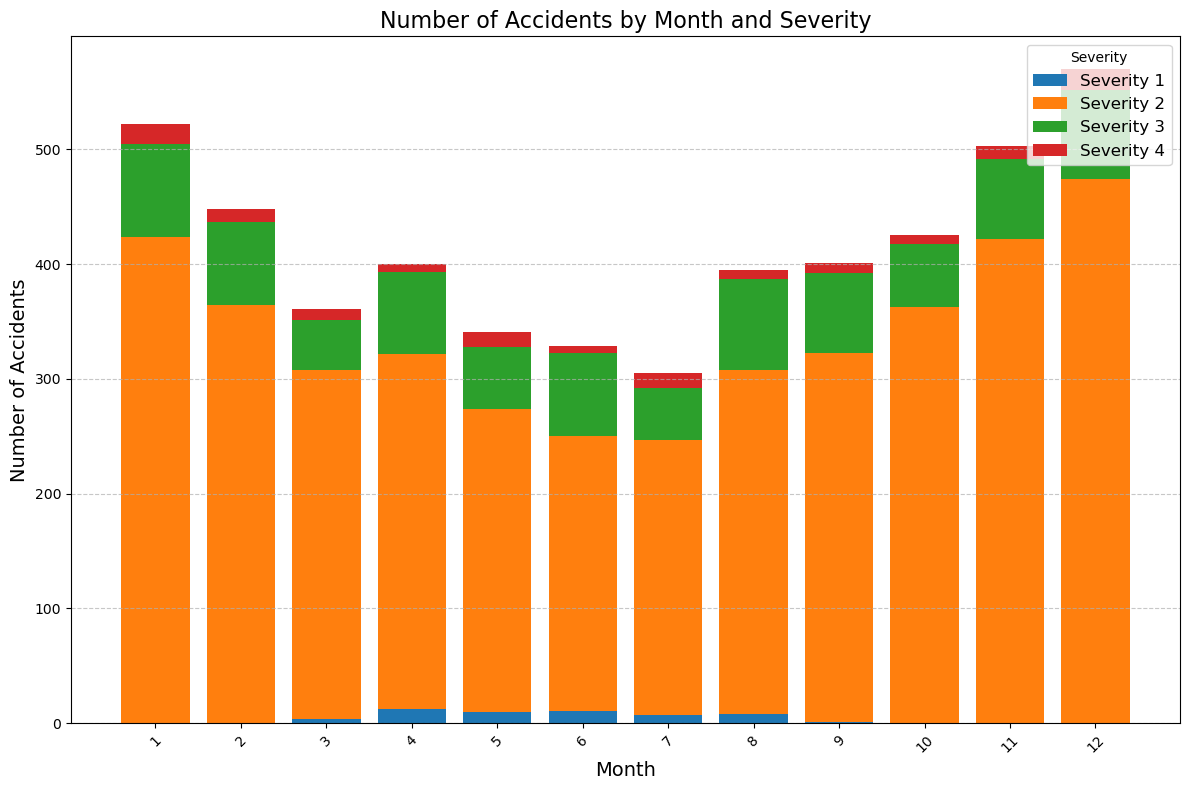

In [130]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_grouped is already created and sorted

# Step 1: Pivot the data to prepare for plotting
# Rows: Months (x-axis), Columns: Severity levels, Values: Count
df_pivot = df_grouped.pivot(index="Month", columns="Severity", values="Count").fillna(0)

# Step 2: Plot the stacked bar chart
plt.figure(figsize=(12, 8))
bottom = None

# Plot each severity level as a segment of the stacked bar
for severity in df_pivot.columns:
    if bottom is None:
        plt.bar(
            df_pivot.index, df_pivot[severity], label=f"Severity {severity}"
        )  # First layer
        bottom = df_pivot[severity]
    else:
        plt.bar(
            df_pivot.index,
            df_pivot[severity],
            bottom=bottom,
            label=f"Severity {severity}",
        )  # Subsequent layers
        bottom += df_pivot[severity]

# Step 3: Add labels, title, and legend
plt.title("Number of Accidents by Month and Severity", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)
plt.xticks(ticks=df_pivot.index, labels=df_pivot.index, rotation=45)
plt.legend(title="Severity", fontsize=12, loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Step 4: Show the plot
plt.tight_layout()
plt.show()

## group by state and year

In [135]:
# Step 1: Extract relevant columns and convert to RDD
rdd = df.select("Start_Time", "State").rdd.map(
    lambda row: (row["Start_Time"].year, row["State"])
)  # Extract month and severity

In [136]:
# Step 2: Map to key-value pairs and count occurrences
rdd_grouped = rdd.map(
    lambda x: ((x[0], x[1]), 1)
).reduceByKey(  # Key: (Month, Severity), Value: 1
    lambda a, b: a + b
)  # Aggregate counts

In [137]:
# Step 3: Convert to a more structured format for plotting
data = rdd_grouped.map(lambda x: (x[0][0], x[0][1], x[1])).collect()
df_grouped = pd.DataFrame(data, columns=["year", "State", "Count"])

In [138]:
df_grouped

,year,State,Count
0,2020,OK,11
1,2017,CA,96
2,2019,OR,31
3,2019,NY,39
4,2022,CA,227
...,...,...,...
298,2020,NE,1
299,2019,MA,2
300,2017,IA,1
301,2017,ID,2


# Accidents by Day of the Week

In [150]:
from pyspark.sql.functions import date_format

# Step 1: Extract the day of the week from Start_Time
df_with_day = df.withColumn("Day_of_Week", date_format("Start_Time", "EEEE"))

# Step 2: Group by the day of the week and count the number of accidents
df_grouped_by_day = df_with_day.groupBy("Day_of_Week").count()

# Step 3: Sort by day of the week in the correct order (Monday, Tuesday, ..., Sunday)
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
df_grouped_by_day = df_grouped_by_day.toPandas()
df_grouped_by_day["Day_of_Week"] = pd.Categorical(
    df_grouped_by_day["Day_of_Week"], categories=day_order, ordered=True
)
df_grouped_by_day = df_grouped_by_day.sort_values(by="Day_of_Week").reset_index(
    drop=True
)

# Step 4: Display the results
print(df_grouped_by_day)

  Day_of_Week  count
0      Monday    779
1     Tuesday    827
2   Wednesday    886
3    Thursday    872
4      Friday    858
5    Saturday    445
6      Sunday    333


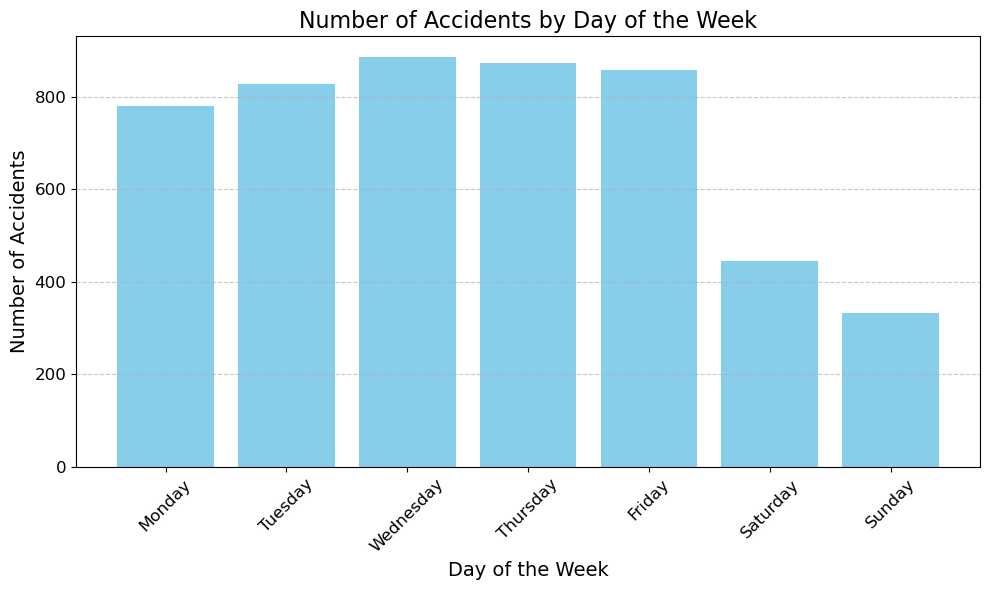

In [151]:
plt.figure(figsize=(10, 6))
plt.bar(df_grouped_by_day["Day_of_Week"], df_grouped_by_day["count"], color="skyblue")
plt.title("Number of Accidents by Day of the Week", fontsize=16)
plt.xlabel("Day of the Week", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

## Hour Analysis

In [154]:
from pyspark.sql.functions import hour
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Convert the dataframe to an RDD and extract the hour from Start_Time
rdd = df.select("Start_Time").rdd.map(lambda row: row["Start_Time"].hour)

# Step 2: Map each hour to a key-value pair and count occurrences using reduceByKey
rdd_grouped = rdd.map(lambda hour: (hour, 1)).reduceByKey(lambda a, b: a + b)

# Step 3: Collect the results and convert to Pandas DataFrame for plotting
data = rdd_grouped.collect()  # Collect the results as a list of tuples
df_grouped_by_hour = pd.DataFrame(
    data, columns=["Hour", "Count"]
)  # Convert to Pandas DataFrame

# Step 4: Sort the DataFrame by hour
df_grouped_by_hour = df_grouped_by_hour.sort_values(by="Hour").reset_index(drop=True)


/var/folders/5j/ky_0t5r527qcj9_0dpjwl4tm0000gn/T/ipykernel_49276/277259780.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


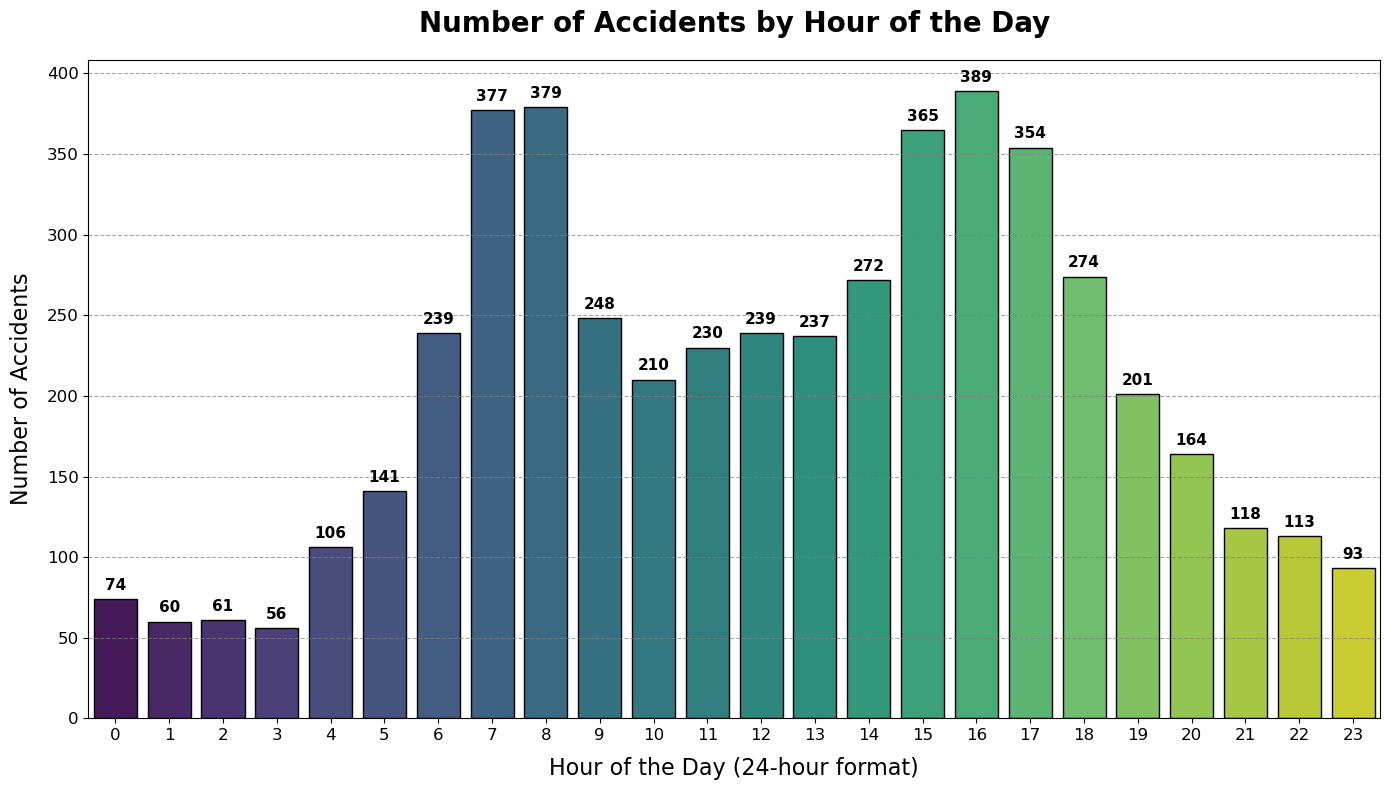

In [155]:
# Step 5: Plot the enhanced bar chart
plt.figure(figsize=(14, 8))
sns.barplot(
    x="Hour",
    y="Count",
    data=df_grouped_by_hour,
    palette="viridis",  # Use a visually appealing color palette
    edgecolor="black",
)

# Add titles and labels with custom styling
plt.title(
    "Number of Accidents by Hour of the Day", fontsize=20, fontweight="bold", pad=20
)
plt.xlabel("Hour of the Day (24-hour format)", fontsize=16, labelpad=10)
plt.ylabel("Number of Accidents", fontsize=16, labelpad=10)

# Format x-ticks and y-ticks
plt.xticks(ticks=range(0, 24), fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.7)

# Annotate each bar with its value
for index, row in df_grouped_by_hour.iterrows():
    plt.text(
        x=row["Hour"],
        y=row["Count"]
        + max(df_grouped_by_hour["Count"]) * 0.01,  # Position slightly above the bar
        s=f"{int(row['Count'])}",  # Display the count value
        ha="center",
        va="bottom",
        fontsize=11,
        color="black",
        weight="bold",
    )

# Adjust layout for better fitting
plt.tight_layout()

# Show the plot
plt.show()